In [1]:
dataset_name = "ibm-common-stock-closing-prices"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 1024

In [2]:
import adclasses
import pandas as pd
import matplotlib.pyplot as plt
import holidays
import joblib
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/framework/ops.py:939: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


# Preprocess Dataset

In [3]:
data = pd.read_csv(path,header=0)
data["Date"] = pd.to_datetime(data["Date"],format="%Y-%m-%d")

data["timestamp"] = data["Date"]
del data["Date"]
data["value"] = data["IBM common stock closing prices"]
del data["IBM common stock closing prices"]

start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)

missing = adclasses.find_missing_time_steps(start_date, end_date, '1D', data)
print("Missing time steps: ", missing)

ad = adclasses.UnivariateAnomalyDetection(dataframe=data, timestep="1D", dateformat="%Y-%m-%d", name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())

true_outlier_dates = ["1965-06-08 00:00:00"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  1962-01-02T00:00:00.000000000
End date:  1965-12-31T00:00:00.000000000
Missing time steps:  DatetimeIndex(['1962-01-06', '1962-01-07', '1962-01-13', '1962-01-14',
               '1962-01-20', '1962-01-21', '1962-01-27', '1962-01-28',
               '1962-02-03', '1962-02-04',
               ...
               '1965-11-28', '1965-12-04', '1965-12-05', '1965-12-11',
               '1965-12-12', '1965-12-18', '1965-12-19', '1965-12-24',
               '1965-12-25', '1965-12-26'],
              dtype='datetime64[ns]', length=452, freq=None)
Length:  1460
Time step size:  1D
Start Date:  1962-01-02T00:00:00.000000000
End Date:  1965-12-31T00:00:00.000000000
Date Format:  %Y-%m-%d
True outlier indices:  [1253]


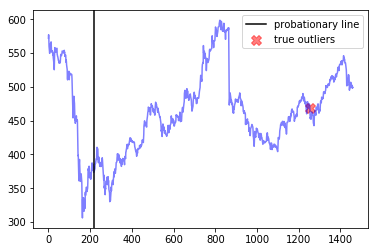

In [4]:
ad.plot_outliers([], true_outlier_indices)

# Donut

Trainable Parameters              (40,030 in total)
---------------------------------------------------
donut/p_x_given_z/x_mean/bias    (60,)           60
donut/p_x_given_z/x_mean/kernel  (100, 60)    6,000
donut/p_x_given_z/x_std/bias     (60,)           60
donut/p_x_given_z/x_std/kernel   (100, 60)    6,000
donut/q_z_given_x/z_mean/bias    (5,)             5
donut/q_z_given_x/z_mean/kernel  (100, 5)       500
donut/q_z_given_x/z_std/bias     (5,)             5
donut/q_z_given_x/z_std/kernel   (100, 5)       500
sequential/_0/dense/bias         (100,)         100
sequential/_0/dense/kernel       (5, 100)       500
sequential/_1/dense/bias         (100,)         100
sequential/_1/dense/kernel       (100, 100)  10,000
sequential_1/_0/dense/bias       (100,)         100
sequential_1/_0/dense/kernel     (60, 100)    6,000
sequential_1/_1/dense/bias       (100,)         100
sequential_1/_1/dense/kernel     (100, 100)  10,000

[Epoch 10/256, Step 0, ETA 0.3364s] Learning rate decreased to 

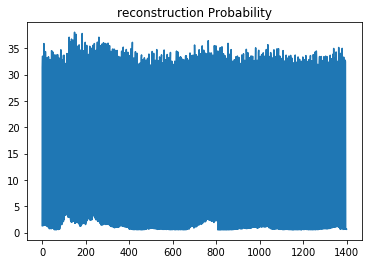

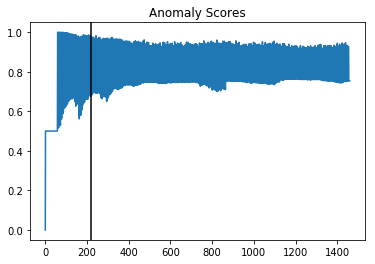

Time:  9.397745132446289


['anomaly_scores/Donut/ibm-common-stock-closing-prices_no_fill']

In [5]:
save_path = "anomaly_scores/Donut/" + dataset_name + "_no_fill"
output_dict = ad.donut(gaussian_window_size=gaussian_window_size,window_size=60, plot_reconstruction_prob=True, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# STL Resid

In [6]:
# no seasonality so no stl